# Analyzing Students' Mental Health

![mental_health](mental_health.jpg)

### Problem Background

Does going to university in a different country affect your mental health? A Japanese international university surveyed its students in 2018 and published a study the following year that was approved by several ethical and regulatory boards.

The study found that international students have a higher risk of mental health difficulties than the general population, and that social connectedness (belonging to a social group) and acculturative stress (stress associated with joining a new culture) are predictive of depression.

[See paper for more info, including data description.](https://www.mdpi.com/2306-5729/4/3/124/htm)

[Link to the data.](https://www.mdpi.com/2306-5729/4/3/124/s1)

Explore the `students` data using PostgreSQL to find out if you would come to a similar conclusion for international students and see if the length of stay is a contributing factor.

Here is a data description of the columns you may find helpful.

| Field Name    | Description                                      |
| ------------- | ------------------------------------------------ |
| `inter_dom`     | Types of students (international or domestic)   |
| `japanese_cate` | Japanese language proficiency                    |
| `english_cate`  | English language proficiency                     |
| `academic`      | Current academic level (undergraduate or graduate) |
| `age`           | Current age of student                           |
| `stay`          | Current length of stay in years                  |
| `todep`         | Total score of depression (PHQ-9 test)           |
| `tosc`          | Total score of social connectedness (SCS test)   |
| `toas`          | Total score of acculturative stress (ASISS test) |

In [ ]:
-- Run this code to save the CSV file as students
SELECT * 
FROM 'students.csv';

,inter_dom,region,gender,academic,age,age_cate,stay,stay_cate,japanese,japanese_cate,english,english_cate,intimate,religion,suicide,dep,deptype,todep,depsev,tosc,apd,ahome,aph,afear,acs,aguilt,amiscell,toas,partner,friends,parents,relative,profess,phone,doctor,reli,alone,others,internet,partner_bi,friends_bi,parents_bi,relative_bi,professional_bi,phone_bi,doctor_bi,religion_bi,alone_bi,others_bi,internet_bi
0,Inter,SEA,Male,Grad,24.0,4.0,5.0,Long,3.0,Average,5.0,High,None,Yes,No,No,No,0.0,Min,34.0,23.0,9.0,11.0,8.0,11.0,2.0,27.0,91.0,5.0,5.0,6.0,3.0,2.0,1.0,4.0,1.0,3.0,4.0,NaN,Yes,Yes,Yes,No,No,No,No,No,No,No,No
1,Inter,SEA,Male,Grad,28.0,5.0,1.0,Short,4.0,High,4.0,High,None,No,No,No,No,2.0,Min,48.0,8.0,7.0,5.0,4.0,3.0,2.0,10.0,39.0,7.0,7.0,7.0,4.0,4.0,4.0,4.0,1.0,1.0,1.0,NaN,Yes,Yes,Yes,No,No,No,No,No,No,No,No
2,Inter,SEA,Male,Grad,25.0,4.0,6.0,Long,4.0,High,4.0,High,Yes,Yes,No,No,No,2.0,Min,41.0,13.0,4.0,7.0,6.0,4.0,3.0,14.0,51.0,3.0,3.0,3.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,NaN,No,No,No,No,No,No,No,No,No,No,No
3,Inter,EA,Female,Grad,29.0,5.0,1.0,Short,2.0,Low,3.0,Average,No,No,No,No,No,3.0,Min,37.0,16.0,10.0,10.0,8.0,6.0,4.0,21.0,75.0,5.0,5.0,5.0,5.0,5.0,2.0,2.0,2.0,4.0,4.0,NaN,Yes,Yes,Yes,Yes,Yes,No,No,No,No,No,No
4,Inter,EA,Female,Grad,28.0,5.0,1.0,Short,1.0,Low,3.0,Average,Yes,No,No,No,No,3.0,Min,37.0,15.0,12.0,5.0,8.0,7.0,4.0,31.0,82.0,5.0,5.0,5.0,2.0,5.0,2.0,5.0,5.0,4.0,4.0,NaN,Yes,Yes,Yes,No,Yes,No,Yes,Yes,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,None,None,None,None,NaN,NaN,NaN,None,NaN,None,NaN,None,None,None,None,None,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46,222,None,None,None,None,None,None,None,None,None
282,None,None,None,None,NaN,NaN,NaN,None,NaN,None,NaN,None,None,None,None,None,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,249,None,None,None,None,None,None,None,None,None
283,None,None,None,None,NaN,NaN,NaN,None,NaN,None,NaN,None,None,None,None,None,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65,203,None,None,None,None,None,None,None,None,None
284,None,None,None,None,NaN,NaN,NaN,None,NaN,None,NaN,None,None,None,None,None,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,247,None,None,None,None,None,None,None,None,None


1. See how many records the dataset has.

In [3]:
-- Count the number of records in the table
SELECT COUNT(*) AS total_records
FROM students;

,total_records
0,286


2. Inspect the dataset to see what the fields look like.

In [4]:
-- Inspect the table 'students' and limit the output to 10 records
SELECT *
FROM students
LIMIT 10;

,inter_dom,region,gender,academic,age,age_cate,stay,stay_cate,japanese,japanese_cate,english,english_cate,intimate,religion,suicide,dep,deptype,todep,depsev,tosc,apd,ahome,aph,afear,acs,aguilt,amiscell,toas,partner,friends,parents,relative,profess,phone,doctor,reli,alone,others,internet,partner_bi,friends_bi,parents_bi,relative_bi,professional_bi,phone_bi,doctor_bi,religion_bi,alone_bi,others_bi,internet_bi
0,Inter,SEA,Male,Grad,24.0,4.0,5.0,Long,3.0,Average,5.0,High,None,Yes,No,No,No,0.0,Min,34.0,23.0,9.0,11.0,8.0,11.0,2.0,27.0,91.0,5.0,5.0,6.0,3.0,2.0,1.0,4.0,1.0,3.0,4.0,NaN,Yes,Yes,Yes,No,No,No,No,No,No,No,No
1,Inter,SEA,Male,Grad,28.0,5.0,1.0,Short,4.0,High,4.0,High,None,No,No,No,No,2.0,Min,48.0,8.0,7.0,5.0,4.0,3.0,2.0,10.0,39.0,7.0,7.0,7.0,4.0,4.0,4.0,4.0,1.0,1.0,1.0,NaN,Yes,Yes,Yes,No,No,No,No,No,No,No,No
2,Inter,SEA,Male,Grad,25.0,4.0,6.0,Long,4.0,High,4.0,High,Yes,Yes,No,No,No,2.0,Min,41.0,13.0,4.0,7.0,6.0,4.0,3.0,14.0,51.0,3.0,3.0,3.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,NaN,No,No,No,No,No,No,No,No,No,No,No
3,Inter,EA,Female,Grad,29.0,5.0,1.0,Short,2.0,Low,3.0,Average,No,No,No,No,No,3.0,Min,37.0,16.0,10.0,10.0,8.0,6.0,4.0,21.0,75.0,5.0,5.0,5.0,5.0,5.0,2.0,2.0,2.0,4.0,4.0,NaN,Yes,Yes,Yes,Yes,Yes,No,No,No,No,No,No
4,Inter,EA,Female,Grad,28.0,5.0,1.0,Short,1.0,Low,3.0,Average,Yes,No,No,No,No,3.0,Min,37.0,15.0,12.0,5.0,8.0,7.0,4.0,31.0,82.0,5.0,5.0,5.0,2.0,5.0,2.0,5.0,5.0,4.0,4.0,NaN,Yes,Yes,Yes,No,Yes,No,Yes,Yes,No,No,No
5,Inter,SEA,Male,Grad,24.0,4.0,6.0,Long,3.0,Average,4.0,High,Yes,No,No,No,No,6.0,Mild,38.0,18.0,8.0,10.0,8.0,7.0,3.0,29.0,83.0,6.0,5.0,4.0,2.0,1.0,1.0,2.0,1.0,5.0,1.0,NaN,Yes,Yes,No,No,No,No,No,No,Yes,No,No
6,Inter,SA,Male,Grad,23.0,4.0,1.0,Short,3.0,Average,5.0,High,Yes,No,No,No,No,3.0,Min,46.0,17.0,6.0,10.0,5.0,3.0,2.0,15.0,58.0,7.0,5.0,7.0,2.0,2.0,1.0,5.0,1.0,1.0,1.0,NaN,Yes,Yes,Yes,No,No,No,Yes,No,No,No,No
7,Inter,SEA,Female,Grad,30.0,5.0,2.0,Medium,1.0,Low,1.0,Low,Yes,Yes,Yes,No,No,9.0,Mild,41.0,16.0,20.0,19.0,15.0,11.0,6.0,40.0,127.0,7.0,2.0,2.0,2.0,6.0,2.0,1.0,1.0,3.0,1.0,NaN,Yes,No,No,No,Yes,No,No,No,No,No,No
8,Inter,SEA,Female,Grad,25.0,4.0,4.0,Long,4.0,High,4.0,High,No,No,No,Yes,Other,7.0,Mild,36.0,22.0,12.0,13.0,13.0,10.0,6.0,33.0,109.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,NaN,No,No,No,No,No,No,No,No,No,No,No
9,Inter,Others,Male,Grad,31.0,5.0,2.0,Medium,1.0,Low,4.0,High,Yes,Yes,No,No,No,3.0,Min,48.0,8.0,4.0,5.0,12.0,3.0,2.0,17.0,51.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,1.0,NaN,No,No,No,No,No,No,No,No,No,No,No


### Missing Values and Imputing
Check if there's any missing values. If so, impute them

In [30]:
# Impute missing values
for column in data.columns:
    if data[column].dtype == 'object':  # Categorical data
        data[column].fillna(data[column].mode()[0], inplace=True)
    else:  # Numerical data
        data[column].fillna(data[column].median(), inplace=True)

# Verify that there are no more missing values
missing_values_count = data.isnull().sum()
missing_values_count

inter_dom          0
region             0
gender             0
academic           0
age                0
age_cate           0
stay               0
stay_cate          0
japanese           0
japanese_cate      0
english            0
english_cate       0
intimate           0
religion           0
suicide            0
dep                0
deptype            0
todep              0
depsev             0
tosc               0
apd                0
ahome              0
aph                0
afear              0
acs                0
aguilt             0
amiscell           0
toas               0
partner            0
friends            0
parents            0
relative           0
profess            0
 phone             0
doctor             0
reli               0
alone              0
others             0
internet           0
partner_bi         0
friends_bi         0
parents_bi         0
relative_bi        0
professional_bi    0
phone_bi           0
doctor_bi          0
religion_bi        0
alone_bi     

### Data Type Conversaion
Ensure that all columns have appropriate data types. Specifically, we'll focus on converting categorical variables (those with a limited number of unique values and represented as strings) to a categorical data type. This can help reduce memory usage and improve performance for certain operations.

In [41]:
# Convert categorical variables to 'category' dtype
categorical_columns = data.select_dtypes(include=['object']).columns
data[categorical_columns] = data[categorical_columns].astype('category')

# Verify the changes
data.dtypes

inter_dom          category
region             category
gender             category
academic           category
age                 float64
age_cate            float64
stay                float64
stay_cate          category
japanese            float64
japanese_cate      category
english             float64
english_cate       category
intimate           category
religion           category
suicide            category
dep                category
deptype            category
todep               float64
depsev             category
tosc                float64
apd                 float64
ahome               float64
aph                 float64
afear               float64
acs                 float64
aguilt              float64
amiscell            float64
toas                float64
partner             float64
friends             float64
parents             float64
relative            float64
profess             float64
 phone              float64
doctor              float64
reli                

In [31]:
-- Basis SQL query
SELECT gender, inter_dom, COUNT(inter_dom)
FROM 'students.csv'

GROUP BY gender, inter_dom
HAVING inter_dom = 'Inter' AND gender = 'Female'

,gender,inter_dom,count(inter_dom)
0,Female,Inter,128


3. How many international and domestic students are in the dataset?

In [32]:
-- Count the number of international and domestic students
SELECT inter_dom, COUNT(inter_dom) AS count_inter_dom
FROM students
GROUP BY inter_dom;

,inter_dom,count_inter_dom
0,Dom,67
1,None,0
2,Inter,201


4. Where are the international students from?

In [33]:
-- See what Region international students are from
SELECT "Region", COUNT(inter_dom) AS count_inter_dom
FROM students
WHERE inter_dom = 'Inter'
GROUP BY "Region";

,region,count_inter_dom
0,EA,48
1,SEA,122
2,SA,18
3,JAP,2
4,Others,11


### Understanding the scores (diagnostic tests: todep, tosc, toas)

In [34]:
-- Find out the basic summary statistics of the diagnostic tests for all students
SELECT MIN("todep") AS min_phq, 
	   MAX("todep") AS max_phq, 
       ROUND(AVG("todep"), 2) AS avg_phq, 
       MIN("tosc") AS min_scs, 
       MAX("tosc") AS max_scs, 
       ROUND(AVG("tosc"), 2) AS avg_scs, 
       MIN("toas") AS min_as, 
       MAX("toas") AS max_as, 
       ROUND(AVG("toas"), 2) AS avg_as
FROM students;

,min_phq,max_phq,avg_phq,min_scs,max_scs,avg_scs,min_as,max_as,avg_as
0,0.0,25.0,8.19,8.0,48.0,37.47,36.0,145.0,72.38


7. What are the summary statistics for domestic students and international students?

In [35]:
-- Summary statistics for domestic students and international students
SELECT inter_dom,
	   MIN("todep") AS min_phq, 
	   MAX("todep") AS max_phq, 
       ROUND(AVG("todep"), 2) AS avg_phq, 
       MIN("tosc") AS min_scs, 
       MAX("tosc") AS max_scs, 
       ROUND(AVG("tosc"), 2) AS avg_scs, 
       MIN("toas") AS min_as, 
       MAX("toas") AS max_as, 
       ROUND(AVG("toas"), 2) AS avg_as
FROM students
WHERE inter_dom IN ('Inter', 'Dom')
GROUP BY inter_dom;

,inter_dom,min_phq,max_phq,avg_phq,min_scs,max_scs,avg_scs,min_as,max_as,avg_as
0,Dom,0.0,23.0,8.61,8.0,48.0,37.64,36.0,112.0,62.84
1,Inter,0.0,25.0,8.04,11.0,48.0,37.42,36.0,145.0,75.56


### International Focus

The study found that international students presented a higher risk of having mental health difficulties. Recall, the data is also skewed towards international students. Let's take a closer look at this student group.

8. How does the age of the international student impact the scores?

In [36]:
-- Find the average scores for each age group of international students, and view them in order
SELECT "Age", 
       ROUND(AVG("todep"), 2) AS avg_phq, 
       ROUND(AVG("tosc"), 2) AS avg_scs, 
       ROUND(AVG("toas"), 2) AS avg_as
FROM students
WHERE inter_dom = 'Inter'
GROUP BY "Age"
ORDER BY "Age";

,age,avg_phq,avg_scs,avg_as
0,17.0,4.67,37.33,70.67
1,18.0,8.75,34.11,80.61
2,19.0,8.44,37.90,74.10
3,20.0,7.35,38.21,73.26
4,21.0,9.23,37.74,75.23
5,22.0,8.36,38.14,70.43
6,23.0,9.67,32.00,81.25
7,24.0,4.67,42.33,74.33
8,25.0,6.11,37.33,80.78
9,27.0,10.00,35.00,42.00


9. How does the duration of the student's stay impact the scores.

In [37]:
-- Find the average scores by length of stay for international students, and view them in order
SELECT "Stay", 
       ROUND(AVG("Todep"), 2) AS avg_phq, 
       ROUND(AVG("Tosc"), 2) AS avg_scs, 
       ROUND(AVG("Toas"), 2) AS avg_as
FROM students
WHERE inter_dom = 'Inter'
GROUP BY "Stay"
ORDER BY "Stay";

,stay,avg_phq,avg_scs,avg_as
0,1.0,7.48,38.11,72.80
1,2.0,8.28,37.08,77.67
2,3.0,9.09,37.13,78.00
3,4.0,8.57,33.93,87.71
4,5.0,0.00,34.00,91.00
5,6.0,6.00,38.00,58.67
6,7.0,4.00,48.00,45.00
7,8.0,10.00,44.00,65.00
8,10.0,13.00,32.00,50.00


### Data Visualization

Data Visualization with Plotly in Python

In [38]:
# Import plotly packages
import plotly.express as px
import plotly.graph_objects as go

### The total scores from the PHQ-9 test

In [49]:
# Create the box plot figure
fig = px.box(

# Select the dataframe
    data_frame=data, 

# Select the column you want to visualize
    x="todep", 
    
# Select the additional column to determine different groups of data    
    color="inter_dom", 

# Select the additional column to determine what information is shown when you hover over the plot
    hover_data=["age"],

# Select the option to view all data points
    points="all",

# Clean up the labels
    title="The total scores from the PHQ-9 test",
    labels={"inter_dom":"Type of Student", "ToDep":"Total PHQ-9 Scores"})

# Show the figure
fig.show()

### Feature Correlation

In [17]:
import plotly.graph_objects as go

# List the columns that are continuous variables
continuous_variables = ['age', 'stay', 'japanese', 'english', 'todep', 'tosc', 'apd', 'ahome', 'aph', 'afear', 'acs', 'aguilt', 'amiscell', 'toas', 'partner', 'friends', 'parents', 'relative', 'profess', 'doctor', 'reli', 'alone', 'others', 'internet']

# Create a subset dataframe only the columns of the continuous variables
data_cont = data[continuous_variables]

# Create a Pearson correlation
data_corr = data_cont.corr(method='pearson')

# Build the Heatmap
fig = go.Figure(go.Heatmap(x=data_corr.columns, y=data_corr.columns, z=data_corr.values.tolist(),
                          zmin=-1, zmax=1))

# Adjust the plot size
fig.update_layout(width=900, height=900)

# Show the plot
fig.show()

### Demographic Analysis:
Average total depression score by international/domestic status and gender

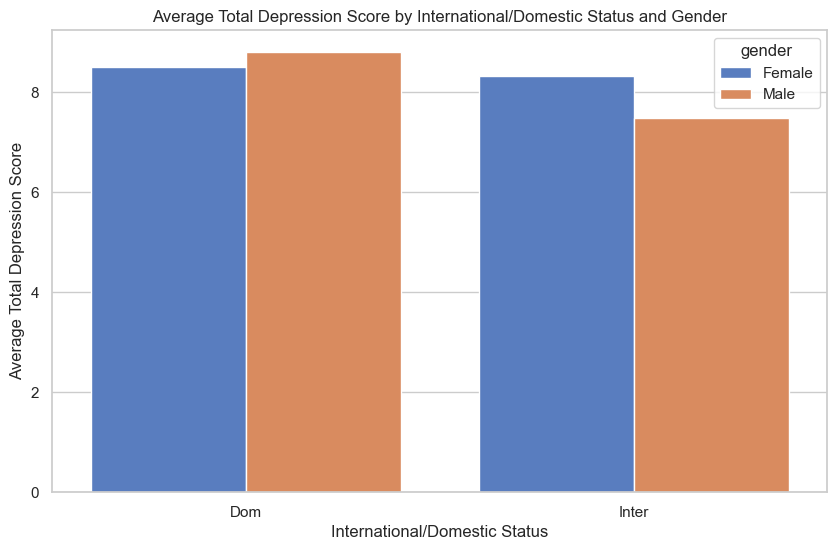

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up the visualization style
sns.set(style="whitegrid")

# Creating a bar plot for average total depression score by international/domestic status and gender
plt.figure(figsize=(10, 6))
sns.barplot(x="inter_dom", y="todep", hue="gender", data=data, estimator=np.mean, ci=None, palette="muted")
plt.title('Average Total Depression Score by International/Domestic Status and Gender')
plt.ylabel('Average Total Depression Score')
plt.xlabel('International/Domestic Status')
plt.show()

Average total depression score by international/domestic status and region

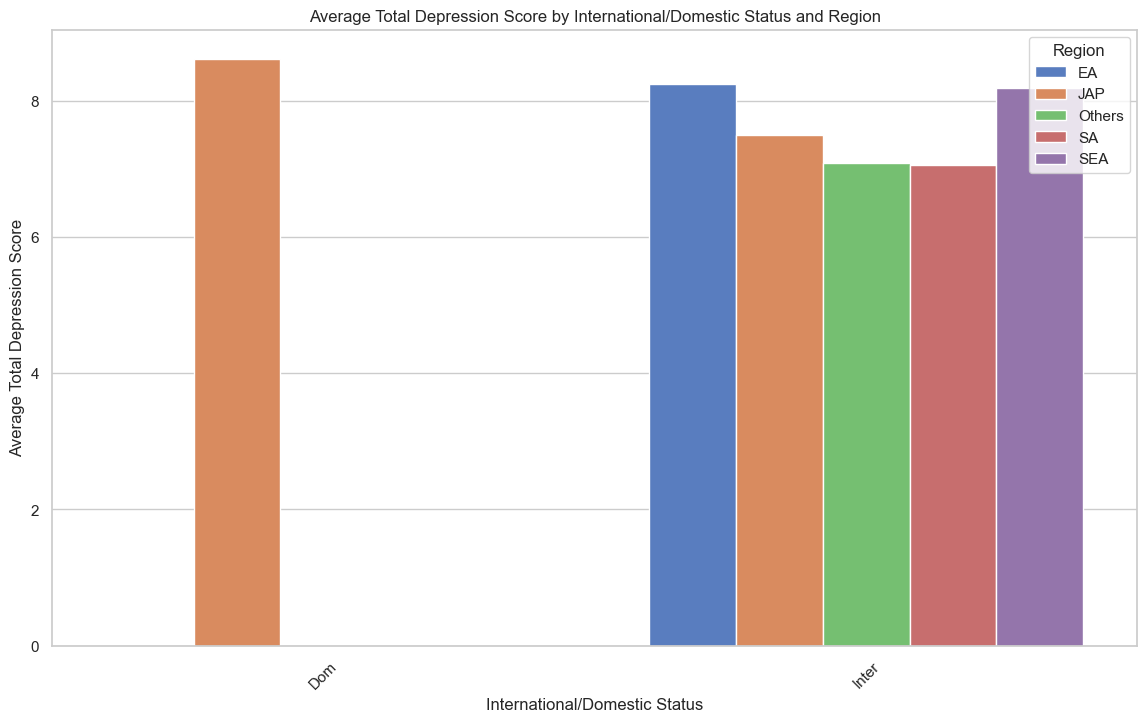

In [45]:
# Creating a bar plot for average total depression score by international/domestic status and region
plt.figure(figsize=(14, 8))
sns.barplot(x="inter_dom", y="todep", hue="region", data=data, estimator=np.mean, ci=None, palette="muted")
plt.title('Average Total Depression Score by International/Domestic Status and Region')
plt.ylabel('Average Total Depression Score')
plt.xlabel('International/Domestic Status')
plt.xticks(rotation=45)
plt.legend(title='Region', loc='upper right')
plt.show()

### Analysis Across Age Groups:
Average total depression score by age group

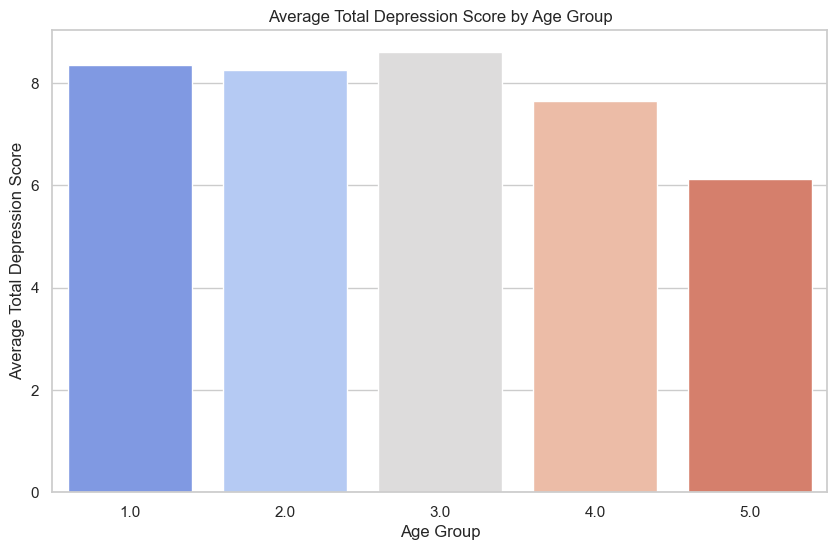

In [53]:
# Creating a bar plot for average total depression score by age group
plt.figure(figsize=(10, 6))
sns.barplot(x="age_cate", y="todep", data=data, estimator=np.mean, ci=None, palette="coolwarm")
plt.title('Average Total Depression Score by Age Group')
plt.ylabel('Average Total Depression Score')
plt.xlabel('Age Group')
plt.show()

Average total acculturative stress score by age group

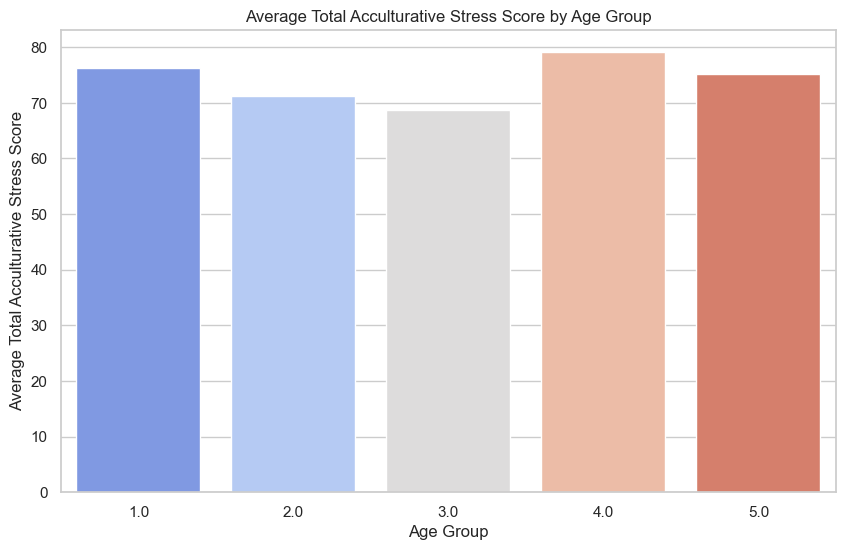

In [55]:
# Creating a bar plot for average total acculturative stress score by age group
plt.figure(figsize=(10, 6))
sns.barplot(x="age_cate", y="toas", data=data, estimator=np.mean, ci=None, palette="coolwarm")
plt.title('Average Total Acculturative Stress Score by Age Group')
plt.ylabel('Average Total Acculturative Stress Score')
plt.xlabel('Age Group')
plt.show()

Average total social connectedness score by age group

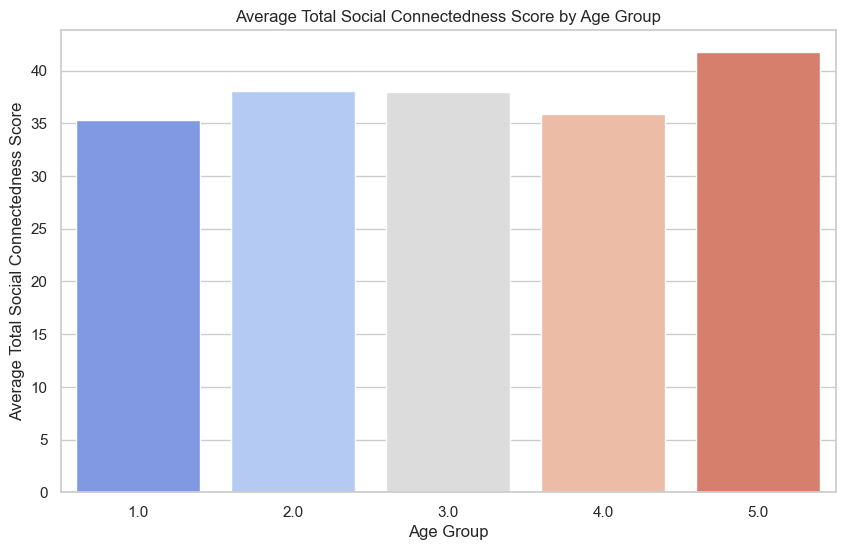

In [57]:
# Creating a bar plot for average total social connectedness score by age group
plt.figure(figsize=(10, 6))
sns.barplot(x="age_cate", y="tosc", data=data, estimator=np.mean, ci=None, palette="coolwarm")
plt.title('Average Total Social Connectedness Score by Age Group')
plt.ylabel('Average Total Social Connectedness Score')
plt.xlabel('Age Group')
plt.show()

### Conclusion:
1) The analysis between international and domestic students suggests differences in mental health outcomes (e.g., depression scores) between the two groups. This could indicate that international students face unique challenges that affect their mental health differently compared to their domestic counterparts.
2) The visualization of depression scores by gender revealed potential disparities in how male and female students experience mental health issues. This highlights the importance of considering gender-specific approaches in mental health support and interventions.
3) The analysis based on students' regions showed variation in depression scores, suggesting that cultural background might influence students' mental health.
4) The examination of mental health scores and social connectedness across age groups provided insights into the varying needs and experiences of students at different stages of their academic and personal lives. Younger and older students may require different forms of support to address their specific challenges.

I hope you find this project useful. Please feel free to reach if you have any question or feedback.